In [1]:
# Input data
import numpy as np
from utilities import *

# test and train read
X_train_valid, Y_train_valid, list_ch_train_valid = read_data(data_path="../../../datasets/har/har-data/", 
                                                              split="train")
X_test, Y_test, list_ch_test = read_data(data_path="../../../datasets/har/har-data/", split="test")

assert list_ch_train_valid == list_ch_test, "Mistmatch in channels!"
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)

print(np.mean(Y_train_valid==0), np.mean(Y_train_valid==1), np.mean(Y_train_valid==2), 
      np.mean(Y_train_valid==3), np.mean(Y_train_valid==4), np.mean(Y_train_valid==5),
      np.mean(Y_train_valid==6), np.mean(Y_train_valid==7))

0.0 0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125 0.0


In [2]:
# Preparing input and output data
# from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid).reshape(-1)==0), np.mean((Y_train_valid).reshape(-1)==1),
     np.mean((Y_train_valid).reshape(-1)==2), np.mean((Y_train_valid).reshape(-1)==3),
     np.mean((Y_train_valid).reshape(-1)==4), np.mean((Y_train_valid).reshape(-1)==5),
     np.mean((Y_train_valid).reshape(-1)==6), np.mean((Y_train_valid).reshape(-1)==7))

Y_train_valid_onehot = one_hot(labels=Y_train_valid.reshape(-1), n_class=6) 
Y_test_onehot = one_hot(labels=Y_test.reshape(-1), n_class=6) 

print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
      Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125 0.0
(7352, 6) float64 (2947, 6) float64


In [3]:
# Train and valid split
from sklearn.model_selection import train_test_split

X_train_norm, X_valid_norm, Y_train_onehot, Y_valid_onehot = train_test_split(X_train_valid_norm, 
                                                                              Y_train_valid_onehot,
                                                                              test_size=0.30)

print(X_train_norm.shape, X_valid_norm.shape, Y_train_onehot.shape, Y_valid_onehot.shape)

(5146, 128, 9) (2206, 128, 9) (5146, 6) (2206, 6)


In [4]:
# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

batch_size, seq_len, n_channels 51 128 9
n_classes 6


In [4]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [6]:
# Feed the data from python/numpy to tensorflow framework
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')

In [7]:
# Construct the LSTM inputs and LSTM cells
# inputs_ (seq_len, N, n_channels)
lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
print(inputs_.shape, lstm_in.shape)

# RNN-LSTM parameters
lstm_size = 3 * n_channels # 3 times the amount of channels
lstm_layers = 1 # Number of layers
print(lstm_size)

# To cells
lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?

# Open up the tensor into a list of seq_len pieces
lstm_in = tf.split(lstm_in, seq_len, 0)

(?, 128, 9) (?, 9)
27


In [8]:
# Add LSTM layers
# lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)
# drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
cell = tf.nn.rnn_cell.MultiRNNCell([lstm] * lstm_layers)
initial_state = cell.zero_state(batch_size, tf.float32)

In [9]:
outputs, final_state = tf.nn.static_rnn(cell, lstm_in, dtype=tf.float32, initial_state = initial_state)

# We only need the last output tensor to pass into a classifier
logits = tf.layers.dense(outputs[-1], n_classes, name='logits')

In [12]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)
print('cost_tensor, cost', cost_tensor, cost)

# Optimizer
optimizer = tf.train.AdamOptimizer().minimize(cost)
print('optimizer', optimizer)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print('correct_pred, accuracy', correct_pred, accuracy)

# # Confusion matrix
# confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
#                                        labels=tf.argmax(labels_, 1))
# print('confusion_matrix', confusion_matrix)

cost_tensor, cost Tensor("softmax_cross_entropy_with_logits_sg_2/Reshape_2:0", shape=(51,), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32)
optimizer name: "Adam"
op: "NoOp"
input: "^Adam/update_dense/kernel/ApplyAdam"
input: "^Adam/update_dense/bias/ApplyAdam"
input: "^Adam/update_rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/ApplyAdam"
input: "^Adam/update_rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias/ApplyAdam"
input: "^Adam/update_logits/kernel/ApplyAdam"
input: "^Adam/update_logits/bias/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"

correct_pred, accuracy Tensor("Equal:0", shape=(51,), dtype=bool) Tensor("accuracy:0", shape=(), dtype=float32)


In [13]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    epochs=100
    for e in range(epochs):
        
        ######################## Training
        # Loop over batches
        # Initialize 
        state = sess.run(initial_state)
        acc_batch, loss_batch = [], []    
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary
            feed_dict = {inputs_ : x, labels_ : y, initial_state : state}
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], feed_dict = feed_dict)
            acc_batch.append(acc)
            loss_batch.append(loss)

        # Store
        train_acc.append(np.mean(acc_batch))
        train_loss.append(np.mean(loss_batch))
            
        ################## Validation
        # Initialize 
        state = sess.run(initial_state)
        acc_batch, loss_batch = [], []    
        # Loop over batches
        for x, y in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

            # Feed dictionary
            feed_dict = {inputs_ : x, labels_ : y, initial_state : state}
            loss, state, acc = sess.run([cost, final_state, accuracy], feed_dict = feed_dict)
            acc_batch.append(acc)
            loss_batch.append(loss)

        # Store
        valid_acc.append(np.mean(acc_batch))
        valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(train_loss[e]),
              "Valid loss: {:.6f}".format(valid_loss[e]),
              "Train acc: {:6f}".format(train_acc[e]),
              "Valid acc: {:.6f}".format(valid_acc[e]))
                
    saver.save(sess,"checkpoints/lstm-har.ckpt")

Epoch: 1/100 Train loss: 1.180627 Valid loss: 0.763284 Train acc: 0.591765 Valid acc: 0.760146
Epoch: 2/100 Train loss: 0.548216 Valid loss: 0.398952 Train acc: 0.828628 Valid acc: 0.901049
Epoch: 3/100 Train loss: 0.311535 Valid loss: 0.264808 Train acc: 0.916667 Valid acc: 0.926585
Epoch: 4/100 Train loss: 0.220571 Valid loss: 0.211860 Train acc: 0.937255 Valid acc: 0.942089
Epoch: 5/100 Train loss: 0.186548 Valid loss: 0.192589 Train acc: 0.941765 Valid acc: 0.941176
Epoch: 6/100 Train loss: 0.155654 Valid loss: 0.158083 Train acc: 0.949412 Valid acc: 0.951664
Epoch: 7/100 Train loss: 0.147784 Valid loss: 0.146117 Train acc: 0.948039 Valid acc: 0.951208
Epoch: 8/100 Train loss: 0.134460 Valid loss: 0.140270 Train acc: 0.950196 Valid acc: 0.953488
Epoch: 9/100 Train loss: 0.128156 Valid loss: 0.133256 Train acc: 0.951176 Valid acc: 0.955768
Epoch: 10/100 Train loss: 0.130982 Valid loss: 0.126876 Train acc: 0.948824 Valid acc: 0.954856
Epoch: 11/100 Train loss: 0.136165 Valid loss: 0.

Epoch: 87/100 Train loss: 0.080275 Valid loss: 0.086986 Train acc: 0.957451 Valid acc: 0.965344
Epoch: 88/100 Train loss: 0.078596 Valid loss: 0.095298 Train acc: 0.959216 Valid acc: 0.962608
Epoch: 89/100 Train loss: 0.077998 Valid loss: 0.086577 Train acc: 0.961373 Valid acc: 0.965344
Epoch: 90/100 Train loss: 0.080352 Valid loss: 0.099261 Train acc: 0.961961 Valid acc: 0.957592
Epoch: 91/100 Train loss: 0.099842 Valid loss: 0.158784 Train acc: 0.955098 Valid acc: 0.940265
Epoch: 92/100 Train loss: 0.082918 Valid loss: 0.088835 Train acc: 0.957843 Valid acc: 0.964888
Epoch: 93/100 Train loss: 0.086438 Valid loss: 0.090366 Train acc: 0.955294 Valid acc: 0.963520
Epoch: 94/100 Train loss: 0.076226 Valid loss: 0.085930 Train acc: 0.961176 Valid acc: 0.965344
Epoch: 95/100 Train loss: 0.076792 Valid loss: 0.097845 Train acc: 0.962745 Valid acc: 0.958960
Epoch: 96/100 Train loss: 0.078608 Valid loss: 0.086940 Train acc: 0.963726 Valid acc: 0.965344
Epoch: 97/100 Train loss: 0.072681 Valid

In [14]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='har train_loss')
mplot.plot(valid_loss, label='har valid_loss')
mplot.legend()
mplot.show()

<Figure size 640x480 with 1 Axes>

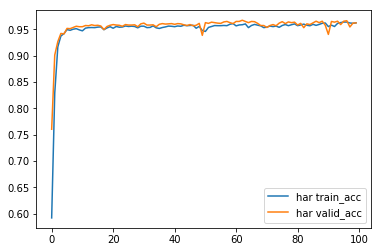

In [15]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc, label='har train_acc')
mplot.plot(valid_acc, label='har valid_acc')
mplot.legend()
mplot.show()

In [5]:
with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    ################## Test
    state = sess.run(initial_state)
    acc_batch, loss_batch = [], []    
    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed_dict = {inputs_ : x, labels_ : y, initial_state : state}
        loss, state, acc = sess.run([cost, final_state, accuracy], feed_dict = feed_dict)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:.6f}".format(np.mean(acc_batch)))

NameError: name 'saver' is not defined